In [162]:
import os
import folium
import pandas as pd
import numpy as np
from folium import plugins
import branca.colormap as cm
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

# Obtain data

In [120]:
import requests
import time
response = requests.get("http://opendata.paris.fr/api/records/1.0/download/?dataset=stations-velib-disponibilites-en-temps-reel&facet=banking&facet=bonus&facet=status&facet=contract_name&rows=-1")
txt = response.text
f = open('velib.csv', 'w+')
f.write(txt)

188975

In [121]:
velibs = pd.read_csv('velib.csv', sep=";")

In [122]:
velibs.head()

,number,name,address,position,banking,bonus,status,contract_name,bike_stands,available_bike_stands,available_bikes,last_update
0,5106,05106 - CUJAS,22 RUE CUJAS - 75005 PARIS,"48.8481913486, 2.34183165485",True,False,OPEN,Paris,19,16,3,2017-09-14T00:08:26+00:00
1,13028,13028 - GOUTHIERE,12 RUE GOUTHIERE - 75013 PARIS,"48.820507, 2.351342",True,False,CLOSED,Paris,33,0,0,2017-09-14T12:20:31+00:00
2,14114,14114 - PLACE DE CATALOGNE,4 RUE ALAIN - 75014 PARIS,"48.8372933094, 2.31748293064",True,True,OPEN,Paris,43,0,0,2017-09-22T09:17:22+00:00
3,35007,35007 - DELESSERT (PANTIN),1 RUE BENJAMIN DELESSERT - 93500 PANTIN,"48.8939437132, 2.41802965969",True,False,OPEN,Paris,21,4,16,2017-09-22T11:05:00+00:00
4,16001,16001 - AVENUE DES PORTUGAIS,2 AVENUE DES PORTUGAIS - 75016 PARIS,"48.8712137122, 2.29369213365",True,True,OPEN,Paris,26,10,16,2017-09-22T12:24:25+00:00


In [123]:
velibs.shape

(1226, 12)

In [124]:
velibs = velibs[velibs.status == 'OPEN']

In [125]:
velibs['arron'] = velibs['address'].map(lambda x: int(x.split()[-2][3:]) if x.split()[-2][:2] == '75' else np.NaN)

In [126]:
velibs.shape

(1186, 13)

In [127]:
velibs.head()

,number,name,address,position,banking,bonus,status,contract_name,bike_stands,available_bike_stands,available_bikes,last_update,arron
0,5106,05106 - CUJAS,22 RUE CUJAS - 75005 PARIS,"48.8481913486, 2.34183165485",True,False,OPEN,Paris,19,16,3,2017-09-14T00:08:26+00:00,5.0
2,14114,14114 - PLACE DE CATALOGNE,4 RUE ALAIN - 75014 PARIS,"48.8372933094, 2.31748293064",True,True,OPEN,Paris,43,0,0,2017-09-22T09:17:22+00:00,14.0
3,35007,35007 - DELESSERT (PANTIN),1 RUE BENJAMIN DELESSERT - 93500 PANTIN,"48.8939437132, 2.41802965969",True,False,OPEN,Paris,21,4,16,2017-09-22T11:05:00+00:00,NaN
4,16001,16001 - AVENUE DES PORTUGAIS,2 AVENUE DES PORTUGAIS - 75016 PARIS,"48.8712137122, 2.29369213365",True,True,OPEN,Paris,26,10,16,2017-09-22T12:24:25+00:00,16.0
5,9034,09034 - GODOT DE MAUROY,2 RUE GODOT DE MAUROY - 75009 PARIS,"48.8699566816, 2.32659965711",True,False,OPEN,Paris,22,1,21,2017-09-22T12:56:20+00:00,9.0


# Number of bike stands

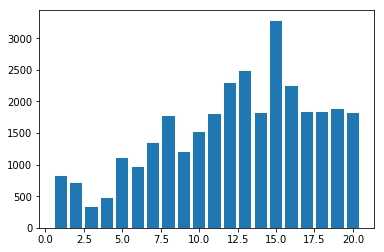

In [135]:
bike_stands_arron = velibs.groupby('arron')['bike_stands'].sum()
plt.bar(bike_stands_arron.index.astype(int), bike_stands_arron.values)
plt.show()

In [136]:
# https://github.com/codeforamerica/click_that_hood/raw/master/public/data/paris.geojson
state_geo = r'paris.json'

m = folium.Map(location=[48.856614, 2.3522219], zoom_start=13, tiles='Stamen Toner')
m.choropleth(geo_path=state_geo, 
             data=bike_stands_arron,
             columns=['arron', 'bike_stands'],
             key_on='properties.cartodb_id',
             fill_color='PuBu', 
             fill_opacity=0.9, line_opacity=0.2,
             legend_name='Number of bike stands',
             highlight=1)
m

# Available bikes

In [137]:
from colour import Color
red = Color("red")
colors = list(red.range_to(Color("green").hex,10))
def red(brightness):
    brightness = int(round(9 * brightness)) # convert from 0.0-1.0 to 0-255
    return colors[brightness]

In [138]:
red(0).hex

'#f00'

In [139]:
velibs['lat'] = velibs['position'].apply(lambda x: float(x.split(",")[0]))
velibs['long'] = velibs['position'].apply(lambda x: float(x.split(",")[1]))
velibs['color'] = velibs.apply(lambda x: red(x['available_bikes']/float(x['bike_stands'])).hex, axis=1)

In [140]:
m = folium.Map(location=[48.856614, 2.3522219], zoom_start=13, tiles='Stamen Toner')

m.add_child(plugins.HeatMap(velibs[['lat','long', 'available_bikes']].values, radius = 20), name='Training location')
colormap = cm.LinearColormap(['blue', 'green',  'yellow', 'orange', 'red'],  index=[0, 0.25, 0.5, 0.75, 1.0]).scale(0,200)
colormap.caption = 'Number of velibs'
m.add_child(colormap)
m

In [141]:
m = folium.Map(location=[48.856614, 2.3522219], zoom_start=13, tiles='Stamen Toner')

for k,v in velibs.iterrows():
    folium.CircleMarker(location=[v.position.split(",")[0], v.position.split(",")[1]], 
                        fill_color=red(v.available_bikes/float(v.bike_stands)).hex,
                        popup= str(v.available_bikes) + " / " + str(v.bike_stands),
                        radius=7).add_to(m)

In [19]:
m

# Utilisation 

In [211]:
df = pd.DataFrame(columns=np.append("Date",velibs.number.values))
path_data = 'data/raw/velib/'
for i, name in tqdm(enumerate(os.listdir(path_data))):
    #print(name.split("velib")[1].split(".")[0])
    velibs_temp = pd.read_csv(path_data + name, sep=";")
    positions = {}
    #print(name.split("velib")[2])
    positions['Date'] = name.split("velib")[1].split(".")[0]
    for k,v in velibs_temp.iterrows():
        positions[str(v.number)] = v.available_bikes
    
    df.loc[i] = pd.Series(positions)


0it [00:00, ?it/s]
1it [00:00,  3.68it/s]
2it [00:00,  3.70it/s]
3it [00:00,  3.73it/s]
4it [00:01,  3.73it/s]
5it [00:01,  3.79it/s]
6it [00:01,  3.73it/s]
7it [00:01,  3.69it/s]
8it [00:02,  3.70it/s]
9it [00:02,  3.76it/s]
10it [00:02,  3.80it/s]
11it [00:02,  3.62it/s]
3045it [14:37,  2.84it/s]


In [212]:
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d-%H-%M', errors='coerce')

In [213]:
df = df.sort_values('Date').reset_index(drop=True)

In [214]:
print(df.shape)
df.head()

(3045, 1187)


,Date,5106,14114,35007,16001,9034,8113,6006,42015,19028,...,23005,19117,12043,10110,16122,7020,15123,1008,7006,1020
0,2017-05-07 09:32:00,0,1,15,2,11,6,4,1,0,...,24,18,27,3,42,54,40,1,17,9
1,2017-05-07 10:32:00,0,1,14,0,11,8,5,1,1,...,25,20,27,3,43,54,42,1,16,10
2,2017-05-07 11:32:00,0,2,15,1,7,8,5,1,1,...,23,17,28,3,45,51,39,4,15,5
3,2017-05-07 12:33:00,2,3,16,0,7,10,6,1,0,...,21,15,30,4,42,57,37,5,10,7
4,2017-05-07 13:33:00,0,0,12,3,9,12,2,3,2,...,21,22,31,2,42,49,42,1,16,4


In [215]:
df.loc[:, df.columns != 'Date'].sum(axis=1).mean()

13533.330157687253

In [284]:
df_grouped = df.groupby([df.Date.dt.dayofweek, df.Date.dt.hour]).agg({lambda x: np.mean(x)}).diff().clip(0).sum(axis=1)

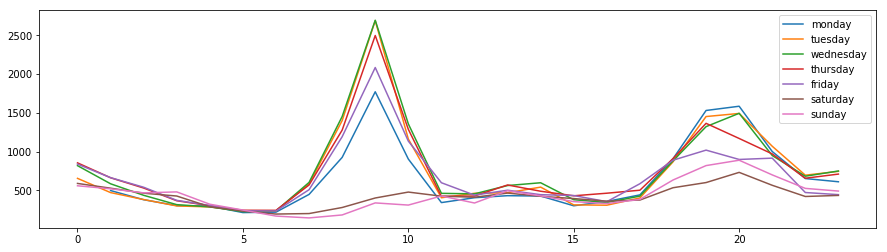

In [303]:
plt.figure(figsize=(15,4))
for i in range(len(weekday)):
    plt.plot(df_grouped.loc[i], label=weekday[i])

plt.legend()
plt.show()

## Save to json

In [289]:
weekday = ['monday','tuesday','wednesday','thursday','friday','saturday','sunday']
json_file = dict()
for i in range(len(weekday)):
    json_file[weekday[i]] = {'hour': df_grouped.loc[i].index.values.tolist(), 'velibs': df_grouped.loc[i].round(1).values.tolist()}

with open('output/velibs.json', 'w') as outfile:
    json.dump({'hourly': json_file}, 
              outfile)

In [34]:
import pygal
from IPython.display import SVG, HTML

In [35]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [38]:
line_chart = pygal.Line(x_title='Time [hour]',y_title='Number of used bikes')
line_chart.title = 'Number of used bikes'
line_chart.x_labels = range(0, 24)
weekday = ['monday','tuesday','wednesday','thursday','friday','saturday','sunday']
for i in range(15,22):
    subdf = df[df['Date'].dt.day == i]
    tmp_df = subdf.ix[:, df.columns != 'Date'].diff().clip(0).sum(axis=1).values[1:]
    line_chart.add(weekday[i-15], tmp_df)

HTML(html_pygal.format(pygal_render=line_chart.render()))